In [1]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torch.optim.lr_scheduler as lr_scheduler


# Data 및 시각화 관련
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [4]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()

        # 은닉층들을 nn.ModuleList로 관리
        layers = []
        in_features = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # 활성화 함수로 ReLU 추가
            in_features = hidden_size  # 다음 레이어의 입력 크기는 현재 레이어의 출력 크기

        # Dropout과 마지막 출력층 추가
        layers.append(nn.Dropout(0.3))  # Dropout 추가
        layers.append(nn.Linear(in_features, output_size))

        self.network = nn.Sequential(*layers)  # Sequential로 레이어 묶음

    def forward(self, x):
        return self.network(x)

In [5]:
mbti_df=pd.read_csv('/content/MBTI.csv')
mbti_df

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


In [6]:
mbti_df['ei_type']=mbti_df['type'].apply(lambda x: 1 if 'I' in str(x) else 0)  # 'I'면 1, 'E'면 0
mbti_df

,posts,type,ei_type
0,know intj tool use interaction people excuse a...,INTJ,1
1,rap music ehh opp yeah know valid well know fa...,INTJ,1
2,preferably p hd low except wew lad video p min...,INTJ,1
3,drink like wish could drink red wine give head...,INTJ,1
4,space program ah bad deal meing freelance max ...,INTJ,1
...,...,...,...
106062,stay frustrate world life want take long nap w...,INFP,1
106063,fizzle around time mention sure mistake thing ...,INFP,1
106064,schedule modify hey w intp strong wing underst...,INFP,1
106065,enfj since january busy schedule able spend li...,INFP,1


In [7]:
r_sampled_df = mbti_df.groupby('type', group_keys=False).apply(lambda x: x.sample(n=40, random_state=42))
r_sampled_df['type'].value_counts()
r_sampled_df['ei_type'] = r_sampled_df['type'].apply(lambda x: 1 if 'E' in x else 0)

In [8]:
result = pd.DataFrame(columns=['posts','ei_type'] )
for index, row in r_sampled_df.iterrows():
    # 각 행의 단어를 분리
    features = row['posts'].split()
    # 해당 단어에 맞는 타겟 값 생성
    targets = [row['ei_type']] * len(features)

    # 결과 데이터프레임에 추가
    dfs = pd.DataFrame({'posts' : features, 'ei_type':targets})
    result = pd.concat([result, dfs], ignore_index=True)

In [9]:
feature=mbti_df['posts'].values
target=mbti_df['ei_type'].astype('float64').values

In [10]:
#벡터화
tfidf = TfidfVectorizer(max_features=5000)  # 최대 5000개의 단어만 사용
X = tfidf.fit_transform(feature)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

#텐서화
X_train_tensor = torch.FloatTensor(X_train.toarray())
X_test_tensor = torch.FloatTensor(X_test.toarray())
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)
x_val_tensor = torch.FloatTensor(X_val.toarray()).to(DEVICE)
y_val_tensor = torch.LongTensor(y_val).to(DEVICE)


In [11]:
## models 폴더 아래 프로젝트 폴더 아래 모델 파일저장
import os

# 저장 경로
SAVE_PATH = './models/mbti/'
# 저장 파일명
SAVE_FILE = 'ei_model_train_wbs.pth'
# 저장 모델구조 및 파라미터 모두 저장
SAVE_MODEL = 'ei_model_all.pth'

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [12]:
train_dataset = MyDataset(X_train_tensor, y_train_tensor)
test_dataset = MyDataset(X_test_tensor, y_test_tensor)
val_dataset = MyDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [13]:
input_size = 5000
hidden_sizes = [1000, 500, 300, 100, 50]
output_size = 1  # 이진 분류

model = MLPModel(input_size, hidden_sizes, output_size)
model.to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=10,verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
print(model)

MLPModel(
  (network): Sequential(
    (0): Linear(in_features=5000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [18]:
# 7. 모델 학습
epochs = 100
LOSS_HISTORY, SCORE_HISTORY = [[],[]],[[],[]]

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    train_pred = []
    train_true = []

    for features, targets in train_loader:
        features, targets = features.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(features).view(-1)
        predicted = torch.round(torch.sigmoid(outputs))
        loss = criterion(outputs, targets.float())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_pred.extend(predicted.detach().cpu().numpy())
        train_true.extend(targets.detach().cpu().numpy())

    train_f1 = f1_score(train_pred, train_true)
    avg_loss_train = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss_train:.4f}, F1: {train_f1:.4f}')

    LOSS_HISTORY[0].append(avg_loss_train)
    SCORE_HISTORY[0].append(train_f1)

    #검증
    model.eval()

    v_pred = []
    v_true = []
    v_loss = 0

    with torch.no_grad():
        for features, targets in val_loader:
            outputs = model(features).view(-1)
            predicted = torch.round(torch.sigmoid(outputs))  # 시그모이드 함수로 확률 변환
            v_pred.extend(predicted.cpu().numpy())
            v_true.extend(targets.cpu().numpy())
            loss = criterion(outputs, targets.float())
            v_loss += loss.item()

        val_f1 = f1_score(train_pred, train_true)
        avg_loss_val = epoch_loss / len(train_loader)

        LOSS_HISTORY[1].append(avg_loss_val)
        SCORE_HISTORY[1].append(val_f1)

    #최적화 스케줄러 인스턴스 업데이트
    scheduler.step(loss)
    print(f'scheduler.num_bad_epochs: {scheduler.num_bad_epochs}',end=' ')
    print(f'scheduler.patience: {scheduler.patience}')

    if len(SCORE_HISTORY[1]) == 1:

        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)

        # 모델 전체 저장
        torch.save(model,SAVE_PATH+SAVE_MODEL)

    else:
        if SCORE_HISTORY[1][-1] >= max(SCORE_HISTORY[1]):
            # torch.save(model.state_dict(),f'{SAVE_PATH}{SAVE_FILE}_{epoch}_{LOSS_HISTORY[1][-1]}')
            torch.save(model.state_dict(),SAVE_PATH+SAVE_FILE)
            # 모델 전체 저장
            torch.save(model,SAVE_PATH+SAVE_MODEL)

#모델 평가
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(DEVICE), targets.to(DEVICE)
        outputs = model(features).view(-1)
        predicted = torch.round(torch.sigmoid(outputs))
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch [1/100], Loss: 0.3222, F1: 0.9118
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [2/100], Loss: 0.2240, F1: 0.9427
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [3/100], Loss: 0.1873, F1: 0.9520
scheduler.num_bad_epochs: 1 scheduler.patience: 10
Epoch [4/100], Loss: 0.1096, F1: 0.9760
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [5/100], Loss: 0.0447, F1: 0.9914
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [6/100], Loss: 0.0138, F1: 0.9974
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [7/100], Loss: 0.0052, F1: 0.9990
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [8/100], Loss: 0.0046, F1: 0.9991
scheduler.num_bad_epochs: 1 scheduler.patience: 10
Epoch [9/100], Loss: 0.0032, F1: 0.9993
scheduler.num_bad_epochs: 0 scheduler.patience: 10
Epoch [10/100], Loss: 0.0030, F1: 0.9995
scheduler.num_bad_epochs: 1 scheduler.patience: 10
Epoch [11/100], Loss: 0.0031, F1: 0.9995
scheduler.num_bad_epochs: 2 scheduler.patience: 

In [19]:
#텍스트와 라벨 데이터 준비
r_posts = result['posts'].values
r_labels = result['ei_type'].astype('float64').values
r_X = tfidf.fit_transform(r_posts)
r_X_test_tensor = torch.FloatTensor(r_X.toarray()).to(DEVICE)
r_y_train_tensor = torch.LongTensor(r_labels).to(DEVICE)
r_val_dataset = MyDataset(x_val_tensor, y_val_tensor)
r_val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for features, targets in r_val_loader:
        outputs = model(features).view(-1)
        predicted = torch.round(torch.sigmoid(outputs))  # 시그모이드 함수로 확률 변환
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.cpu().numpy())

#성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8949
F1 Score: 0.9311


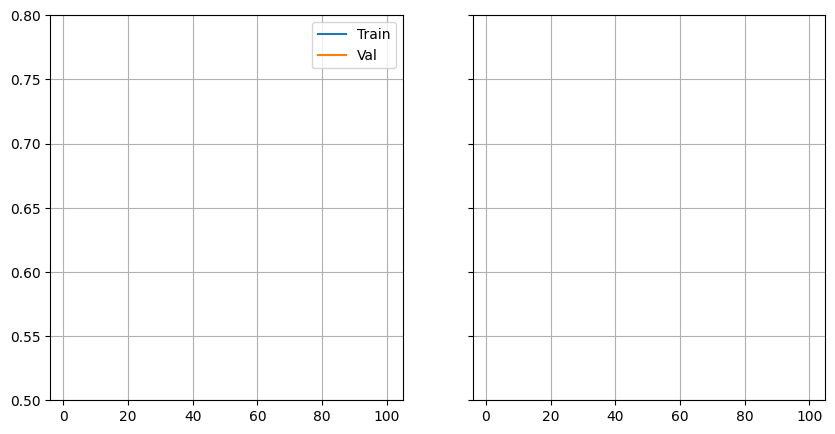

In [22]:
#학습 결과 확인(학습과 검증의 Loss, 성능지표 변화 확인) w. 시각화

th=len(SCORE_HISTORY[1])
fg,axes=plt.subplots(1,2,figsize=(10,5),sharey=True)
axes[0].plot(range(1,th+1),LOSS_HISTORY[0][:th],label='Train')
axes[0].plot(range(1,th+1),LOSS_HISTORY[1][:th],label='Val')
axes[0].set_ylim([0.5,0.8])
axes[0].grid()
axes[0].legend()

axes[1].plot(range(1,th+1),SCORE_HISTORY[0][:th],label='Train')
axes[1].plot(range(1,th+1),SCORE_HISTORY[1][:th],label='Val')
axes[1].grid()

axes[1].legend

plt.show()